In [7]:
import os, re, gzip
from __future__ import print_function, division


def get_file_handle(filename,mode="r"):                                         
    if (re.search('.gz$',filename) or re.search('.gzip',filename)):             
        if (mode=="r"):                                                         
            mode="rb";                                                          
        elif (mode=="w"):                                                       
            #I think write will actually append if the file already             
            #exists...so you want to remove it if it exists                     
            if os.path.isfile(filename):                                        
                os.remove(filename);                                            
        return gzip.open(filename,mode)                                         
    else:                                                                       
        return open(filename,mode) 
    
def get_indel_variant_allele_frequencies(record):
    refcounts = record.genotype("TUMOR").data.TAR
    altcounts = record.genotype("TUMOR").data.TIR
    #following https://github.com/Illumina/strelka/blob/master/docs/userGuide/README.md#somatic
    vaf = float(altcounts[0])/(altcounts[0] + refcounts[0])
    return vaf

In [1]:
#install pyvcf
import vcf

#When I filter `somatic.indels.vcf.gz` down to all rows that contained a “PASS” in the filter column,
#the file size goes from 15M to 164K. Something to keep in mind.
#The command I used to do the filtering was
#zcat somatic.indels.vcf.gz | perl -lane 'if ((substr($_,0,1) eq "#") or ($F[6] eq 'PASS')) {print $_}' | gzip -c > passing_somatic.indels.vcf.gz

somatic_vcf_file_path = "data/somatic/results/variants/passing_somatic.indels.vcf.gz"
vcf_reader = vcf.Reader(open(somatic_vcf_file_path))
#in the vcf format, the rows with 'PASS' show up with no filters
#the len(x.FILTER)==0 check is there just to be on the safe side,
#in case the input hasn't been filtered.
records = [x for x in vcf_reader if len(x.FILTER)==0]

In [8]:
print(len(records)) #before filtering for variant allele frequency

2686


In [24]:
print(records[0])
print(records[0].genotype('TUMOR').data)

Record(CHROM=chr10, POS=1102570, REF=GGGT, ALT=[G])
CallData(DP=52, DP2=52, TAR=[39, 45], TIR=[5, 5], TOR=[10, 6], DP50=54.06, FDP50=2.07, SUBDP50=0.0, BCN50=0.04)


In [10]:
import numpy as np
vafs = np.array([get_indel_variant_allele_frequencies(x) for x in records])

In [11]:
#DP50 is average tier1 read depth within 50bp. Based on:
#https://sites.google.com/site/strelkasomaticvariantcaller/home/somatic-variant-output
tumor_tier1_read_depths = np.array([(x.genotype('TUMOR').data.DP50 - x.genotype('TUMOR').data.FDP50)
                                    for x in records])

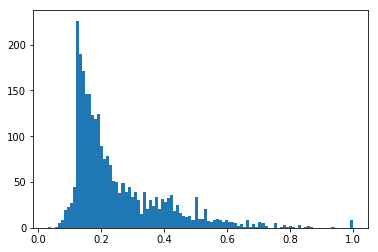

In [12]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.hist(vafs, bins=100)
plt.show()

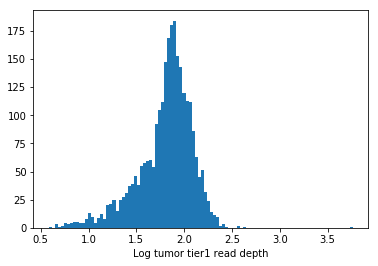

In [13]:
plt.hist(np.log(tumor_tier1_read_depths)/np.log(10), bins=100)
plt.xlabel("Log tumor tier1 read depth")
plt.show()


In [25]:
write_to_file = True #writing out files will take time

#Disclaimer: I do not know what a good VAF threshold is. I note
#that most of the stuff that comes up when I set a threshold of 1.0
#is from chrY, which seeems like an artifact.
vaf_thresholds = [0.2, 0.4, 0.6, 0.8, 0.9, 1.0]#[0.0, 0.05, 0.1, 0.2, 0.4, 0.6, 0.8, 0.9, 1.0

min_read_depth = 12
#max_read_depth = 500

for vaf_threshold in vaf_thresholds:
    if (write_to_file):
        vcf_writer = vcf.Writer(open("data/somatic/results/variants/VAF_"+str(vaf_threshold)+"_somatic.indels.vcf",'w'),
                         vcf_reader)
    total_num = 0
    total_tumor_tier1_reads = 0
    total_tumor_reads = 0
    for vaf,record in zip(vafs,records):
        if (vaf >= vaf_threshold):         
            #DP and FDP are described here: https://sites.google.com/site/strelkasomaticvariantcaller/home/somatic-variant-output
            #DP is read depth, FDP is filtered read depth
            tier1_reads = record.genotype('TUMOR').data.DP50 - record.genotype('TUMOR').data.FDP50
            #total_tumor_reads += record.genotype('TUMOR').data.DP 
            if (tier1_reads >= min_read_depth):
                total_num += 1
                total_tumor_tier1_reads += tier1_reads
                if (write_to_file):
                    vcf_writer.write_record(record)
    print("\nthreshold",vaf_threshold,"num",total_num)
    if (total_num > 0):
        print("Mean tier1 read depth:",total_tumor_tier1_reads/total_num)
    if (write_to_file):
        vcf_writer.close()


threshold 0.2 num 1238
Mean tier1 read depth: 70.8094668821

threshold 0.4 num 378
Mean tier1 read depth: 69.3973015873

threshold 0.6 num 59
Mean tier1 read depth: 55.4728813559

threshold 0.8 num 10
Mean tier1 read depth: 48.423

threshold 0.9 num 3
Mean tier1 read depth: 46.1233333333

threshold 1.0 num 2
Mean tier1 read depth: 56.32
